# Final Project STAT 259: Single Cell Sequencing Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import keras
from keras import layers
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import save_model, load_model

2022-05-06 22:19:40.551989: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :
2022-05-06 22:19:40.552039: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Read data

In [2]:
def setup_data(name):
    """
    ...
    """
    file = f"data/{name}-counts.csv"
    counts = pd.read_csv(file)
    counts.rename(columns={'Unnamed: 0':'index'}, inplace=True)
    counts.set_index("index", inplace=True)
    counts = counts.T
    counts.insert(0, 'cell_label', name)
    return counts

In [3]:
organs = [
    "Kidney",
    "Liver",
]

In [4]:
assert len(organs) == 2

## Feature filter

In [5]:
data = pd.DataFrame()
for organ in organs:
    data = data.append(setup_data(organ))
data.shape

(1846, 23434)

In [6]:
# Remove gene counts with zero variance
std = data.std(axis=0, numeric_only=True)
final_features = list(std[std != 0].index)
data = data[final_features + ["cell_label"]]
data.shape

(1846, 18471)

In [7]:
std = std[final_features]

In [8]:
mu = data.groupby(data["cell_label"]).mean().T

In [9]:
score = np.abs((mu[organs[0]] - mu[organs[1]])/std).sort_values(ascending=False)
score.head(20)

index
Sepp1        0.781411
Bhmt         0.750014
Psen2        0.731537
Gnmt         0.722756
Cd302        0.717035
Cdo1         0.709682
Hpd          0.700787
Fgl1         0.699458
Arg1         0.693576
Serpina1b    0.692899
Tat          0.687784
Serpina1a    0.685803
Otc          0.683865
Adh1         0.679625
Fgb          0.674998
Crp          0.672600
Hmgcs2       0.671819
Apoh         0.670908
Fgg          0.670600
Apoc3        0.669172
dtype: float64

In [10]:
# Choose subset of gene counts
num_genes = 1000
selected_features = list(score.iloc[:num_genes].index)
data = data[selected_features + ["cell_label"]]
data.shape

(1846, 1001)

## Feature preprocessing

In [11]:
data.iloc[:, :-1] = np.log(data.iloc[:,:-1] + 1)

In [12]:
filepath = "processed_data/data.csv"
data.to_csv(filepath, index=True)

# Lower-dimension representation of the cells

In [13]:
data = pd.read_csv(filepath, index_col=0)

In [14]:
data

,Sepp1,Bhmt,Psen2,Gnmt,Cd302,Cdo1,Hpd,Fgl1,Arg1,Serpina1b,...,Nop10,Alkbh5,Dhdh,Defb1,Aldob,Tgds,Cml1,Mrps24,Atf3,cell_label
A14.MAA000545.3_8_M.1.1,5.105945,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.098612,0.000000,4.356709,0.000000,0.000000,0.000000,0.000000,0.000000,Kidney
E1.MAA000545.3_8_M.1.1,5.700444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.875197,0.000000,7.108244,0.000000,0.000000,0.000000,0.693147,Kidney
M4.MAA000545.3_8_M.1.1,2.639057,0.000000,0.000000,0.000000,0.000000,4.744932,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,6.082219,0.000000,0.000000,0.000000,0.000000,0.000000,Kidney
O21.MAA000545.3_8_M.1.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.890372,0.000000,0.000000,3.526361,0.000000,0.000000,0.000000,0.000000,3.637586,Kidney
P4.MAA000545.3_8_M.1.1,6.175867,0.000000,0.000000,5.638355,2.639057,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,8.063063,0.000000,0.000000,3.828641,0.000000,Kidney
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C7.MAA100042.3_9_M.1.1,8.939712,7.624131,6.390241,8.744488,6.111467,6.177944,6.447306,4.836282,7.880426,9.179572,...,6.016157,3.135494,0.000000,0.000000,9.200795,4.110874,7.949797,5.572154,5.648974,Liver
A9.MAA100042.3_9_M.1.1,8.275631,7.848153,5.159055,8.014997,5.968708,4.454347,7.652071,3.496508,7.091742,8.744488,...,4.905275,3.332205,5.433722,0.000000,7.918629,0.693147,4.406719,5.978886,0.000000,Liver
C9.MAA100042.3_9_M.1.1,7.838738,7.412764,5.298317,7.422971,5.648974,6.700731,7.513164,5.117994,5.762051,7.859413,...,4.553877,1.945910,2.995732,0.000000,7.664347,3.828641,5.241747,4.905275,1.609438,Liver
A10.MAA100042.3_9_M.1.1,0.000000,0.000000,0.693147,0.000000,0.000000,1.098612,0.000000,0.693147,0.693147,1.791759,...,0.693147,0.000000,0.000000,0.000000,1.945910,0.000000,0.000000,0.000000,0.000000,Liver


In [15]:
x = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [16]:
# One hot encoding of y labels
# Order chosen by proportions in sample and kept in y_labels
y_hot = pd.get_dummies(y)
y_labels = y_hot.mean(axis=0).sort_values(ascending=False).index
y_hot = y_hot[y_labels]
y_hot.head()

,Liver,Kidney
A14.MAA000545.3_8_M.1.1,0,1
E1.MAA000545.3_8_M.1.1,0,1
M4.MAA000545.3_8_M.1.1,0,1
O21.MAA000545.3_8_M.1.1,0,1
P4.MAA000545.3_8_M.1.1,0,1


In [17]:
# 80:20 split shuffling data
x_train, x_test, y_train, y_test = train_test_split(x, y_hot, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [18]:
# Shape validation for x
x.shape, x_train.shape, x_test.shape

((1846, 1000), (1476, 1000), (370, 1000))

In [19]:
# Shape validation for y
y.shape, y_train.shape, y_test.shape

((1846,), (1476, 2), (370, 2))

## Autoencoder

In [20]:
# Latent space of 32 dimensions
# 1 hidden layer for encoder and one for decoder
# L1 regularization used in fully connected layers
# Encoder will be defined later after training

encoding_dim = 32
input_dim = x.shape[1]

input_obj = keras.Input(shape=(input_dim,))
dropout1 = layers.Dropout(.2)(input_obj)
hidden1 = layers.Dense(128, activation='relu', 
                       activity_regularizer=regularizers.l1(10e-5))(dropout1)
dropout2 = layers.Dropout(.2)(hidden1)
encoded = layers.Dense(encoding_dim, activation='relu', 
                       activity_regularizer=regularizers.l1(10e-5))(dropout2)
dropout3 = layers.Dropout(.2)(encoded)
hidden2 = layers.Dense(128, activation='relu')(dropout3)
dropout4 = layers.Dropout(.2)(hidden2)
decoded = layers.Dense(input_dim, activation='sigmoid')(dropout4)

autoencoder = keras.Model(input_obj, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 128)               128128    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               4224  

2022-05-06 22:19:54.842801: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :
2022-05-06 22:19:54.842907: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-06 22:19:54.843014: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-catalina-2evillouta): /proc/driver/nvidia/version does not exist
2022-05-06 22:19:54.850921: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
# Configurations for improving training with the aim to reduce over-fitting 
# and also allow to seek for a lower bias model.
# Reference: https://stackoverflow.com/questions/48285129/saving-best-model-in-keras
earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')
mcp_save = ModelCheckpoint('models/autoencoder_best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, min_delta=1e-4, mode='min')

In [22]:
# Used MSE as loss
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(
    x_train, x_train,
    epochs=500,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
    verbose=0,
)

In [23]:
# Load best
autoencoder = load_model('models/autoencoder_best.hdf5', compile=False)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
# Evaluate autoencoder performance
autoencoder.evaluate(x_test, x_test)

12/12 [==============================] - 0s 3ms/step - loss: 4.7301


4.730064392089844

In [25]:
# Encoder
encoder_output = autoencoder.layers[4].output
encoder_input = autoencoder.input
encoder = keras.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 128)               128128    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
Total params: 132,256
Trainable params: 132,256
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Save model
encoder.compile(optimizer='adam', loss='mean_squared_error')
save_model(encoder, 'models/encoder_best.hdf5', save_format='hdf5')

In [27]:
# PCA
pca32 = PCA(n_components=32)
x_pca = pca32.fit_transform(x)

In [28]:
# t-SNE
tsne2 = TSNE(n_components=2, learning_rate=200, init='random', method='exact')
x_tsne2 = tsne2.fit_transform(x_pca)

In [29]:
# Encoder used to get input data's latent variables
x_encoded = encoder.predict(x)
x_encoded.shape

(1846, 32)

In [30]:
# Encoder to 32 dim, then t-SNE to 2 dim
x_encoded_tsne2 = tsne2.fit_transform(x_encoded)

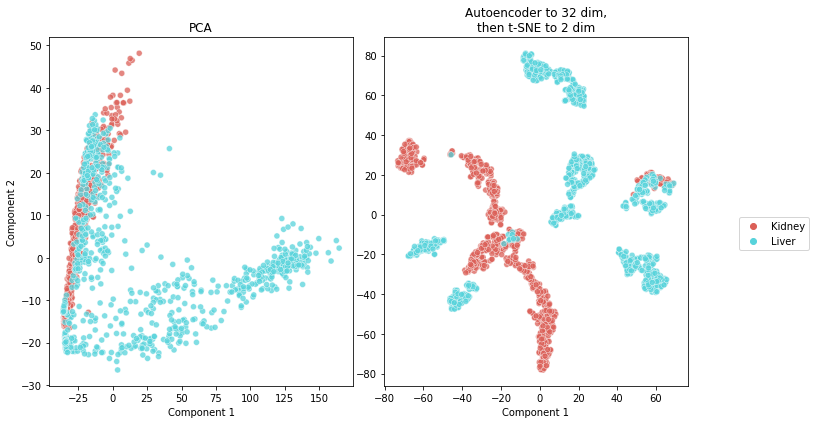

In [31]:
# Plot 2D representations
ncols = 2
fig, ax = plt.subplots(1, ncols, figsize=(12, 6))

x_dict = {
    'PCA': x_pca[:, :2],
    #'t-SNE': x_tsne2,
    'Autoencoder to 32 dim,\nthen t-SNE to 2 dim': x_encoded_tsne2,
}

n = len(x_dict)

for i, (title, x_plot) in enumerate(x_dict.items()):

    col = i
    ax_i = ax[col]

    sns.scatterplot(
        x=x_plot[:,0], y=x_plot[:,1],
        hue=y,
        palette=sns.color_palette("hls", 2),
        legend="full",
        alpha=0.75,
        ax=ax_i)
    if i == n - 1:
        handles, labels = ax_i.get_legend_handles_labels()
    ax_i.get_legend().remove()
    ax_i.set_title(title)
    ax_i.set_xlabel('Component 1')
    if col == 0:
        ax_i.set_ylabel('Component 2')

fig.legend(handles, labels, bbox_to_anchor=(0.9, 0.4), loc='lower center', ncol=1)
fig.tight_layout()
fig.subplots_adjust(right=0.8)

plt.savefig('figures/projection.jpg', format='jpg')
plt.show()

# Classifier

## Cross Validation

In [32]:
def initilize_supervised_model(size):
    """
    - Loads trained encoder
    - Adds layers according to size given (size in ['small', 'larger'])
      for supervized learning set up (label prediction)
    - Returns supervised model with untrained added layers
      but first layers, coming from encoder, are trained already
    """

    assert size in ['small', 'larger']

    # Load encoder
    encoder_load = load_model('models/encoder_best.hdf5', compile=False)

    # Add layers
    encoder_output = encoder_load.layers[-1].output
    encoder_input = encoder_load.input
    if size == 'small':
        # Small model
        dropout = layers.Dropout(.2)(encoder_output)
        output = layers.Dense(2, activation='softmax')(dropout)
        nn_model = keras.Model(encoder_input, output)
    elif size == 'larger':
        # Larger model
        dropout_output1 = layers.Dropout(.2)(encoder_output)
        dense_output1 = layers.Dense(16, activation='relu')(dropout_output1)
        dropout_output2 = layers.Dropout(.2)(dense_output1)
        output = layers.Dense(2, activation='softmax')(dropout_output2)
        nn_model = keras.Model(encoder_input, output)

    # Fix encoder parameters to avoid overfitting
    idx_not_train = [1, 2, 3, 4]
    for i in idx_not_train:
        nn_model.layers[i].trainable = False

    nn_model.compile(optimizer='adam', loss='categorical_crossentropy')

    return nn_model

In [33]:
# Small model quick validation
nn_small = initilize_supervised_model('small')
nn_small.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 128)               128128    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 2)                 66  

In [34]:
# Larger model quick validation
nn_larger = initilize_supervised_model('larger')
nn_larger.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 128)               128128    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                528 

In [35]:
# Call backs

# Early stopping
earlyStopping = EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    verbose=0, 
    mode='min'
)

# Reduce learning rate on plateu
reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=10, 
    min_delta=1e-4, 
    mode='min',
    verbose=0,
)

# Save best model by validation loss
def mcp_save(size):
    return ModelCheckpoint(
      f"models/nn_{size}_best.hdf5", 
      save_best_only=True, 
      monitor='val_loss', 
      mode='min',
    )

In [36]:
def compute_metrics(y_true, y_score, average='macro'):
    assert y_true.shape == y_score.shape
    y_ind_pred = np.argmax(y_score, axis=1)
    y_ind_true = np.argmax(y_true, axis=1)
    accuracy = metrics.accuracy_score(y_ind_true, y_ind_pred)
    precision = metrics.precision_score(y_ind_true, y_ind_pred, average=average)
    recall = metrics.recall_score(y_ind_true, y_ind_pred, average=average)
    f1 = metrics.f1_score(y_ind_true, y_ind_pred, average=average)
    roc_auc = metrics.roc_auc_score(y_true, y_score, average=average)
    return {
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1": f1,
      "roc_auc": roc_auc,
    }

In [37]:
# Cross validation

def nn_cross_validation(size, x, y, n_split=3):
    
    print(f"Cross-validation for size = {size}")

    # Stratified k-fold is used
    kfold = StratifiedKFold(n_split, shuffle=True, random_state=0)

    # Reset index
    xx = x.copy().reset_index(drop=True)
    yy = y.copy().reset_index(drop=True)
    yy_ind = np.argmax(yy.values, axis=1)

    rows = []
    for i, (train_index, test_index) in enumerate(kfold.split(xx, yy_ind)):

        # Split
        xx_train, xx_test = xx.loc[train_index], xx.loc[test_index]
        yy_train, yy_test = yy.loc[train_index], yy.loc[test_index]

        # Train and save model
        nn_model = initilize_supervised_model(size)
        nn_model.fit(
            xx_train, yy_train,
            epochs=500,
            batch_size=256,
            shuffle=True,
            validation_data=(xx_test, yy_test),
            callbacks=[earlyStopping, mcp_save(size), reduce_lr_loss],
            verbose=0,
        )

        # Load best model
        nn_model = load_model(f"models/nn_{size}_best.hdf5", compile=False)
        nn_model.compile(optimizer='adam', loss='categorical_crossentropy')

        # Assess performance
        loss = nn_model.evaluate(xx_test, yy_test, verbose=0)
        y_true = yy_test.values
        y_score = nn_model.predict(xx_test)
        row_dict = compute_metrics(y_true, y_score)
        row_dict['categorical_crossentropy'] = loss
        rows.append(row_dict)

    # Collect performance results
    results = pd.DataFrame.from_dict(rows, orient='columns')
    results = results.reset_index().rename(columns={'index': 'fold'})

    return results

In [38]:
# Cross-validation results for small model: folds details
res_cv_small = nn_cross_validation("small", x_train, y_train)
res_cv_small

Cross-validation for size = small


,fold,accuracy,precision,recall,f1,roc_auc,categorical_crossentropy
0,0,0.941057,0.940531,0.941708,0.940928,0.990098,0.167233
1,1,0.949187,0.949104,0.948873,0.948984,0.988738,0.190427
2,2,0.922764,0.922140,0.923233,0.922548,0.986691,0.170961


In [39]:
# Cross-validation results for larger model: folds details
res_cv_larger = nn_cross_validation("larger", x_train, y_train)
res_cv_larger

Cross-validation for size = larger


,fold,accuracy,precision,recall,f1,roc_auc,categorical_crossentropy
0,0,0.936992,0.936773,0.938374,0.936917,0.991806,0.156335
1,1,0.973577,0.973884,0.973105,0.973458,0.992851,0.159683
2,2,0.941057,0.940569,0.941205,0.940851,0.992234,0.157074


In [40]:
# Cross-validation aggregated results for both models
res_cv = pd.concat((res_cv_small.iloc[:,1:].mean(axis=0), res_cv_larger.iloc[:,1:].mean(axis=0)), axis=1).T.round(3)
res_cv.index = ['small', 'larger']
res_cv

,accuracy,precision,recall,f1,roc_auc,categorical_crossentropy
small,0.938,0.937,0.938,0.937,0.989,0.176
larger,0.951,0.950,0.951,0.950,0.992,0.158


## Test Performance

In [41]:
def plot_roc_curve(name, y_true, y_score, indices, filename=None, extension=None):

    plt.figure(figsize=(10, 7))

    # Compute and plot fpr and tpr per selected labels/indices
    for ind in indices:
        y_score_ind = y_score[:, ind]
        y_true_ind = y_true == ind
        fpr, tpr, threshold = metrics.roc_curve(y_true_ind, y_score_ind)
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label = f"{y_labels[ind]} (AUC={roc_auc:.2f})")

    if name:
        plt.title(f'Receiver Operating Characteristic {name}')
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    if filename:
        plt.savefig(f'figures/{filename}.{extension}', format=extension)
    plt.show()

In [42]:
# Load last model trained in cross-validation
# Training needs a validation set so any fold model is OK
nn_small = load_model(f"models/nn_small_best.hdf5", compile=False)
nn_larger = load_model(f"models/nn_larger_best.hdf5", compile=False)
nn_small.compile(optimizer='adam', loss='categorical_crossentropy')
nn_larger.compile(optimizer='adam', loss='categorical_crossentropy')

In [43]:
# Truth and predictions
y_true = y_test.values
y_true_ind = np.argmax(y_true, axis=1)
y_score_small = nn_small.predict(x_test)
y_score_larger = nn_larger.predict(x_test)

In [44]:
# Confusion matrix
conf_matrix_small = metrics.confusion_matrix(y_true_ind, np.argmax(y_score_small, axis=1))
conf_matrix_larger = metrics.confusion_matrix(y_true_ind, np.argmax(y_score_larger, axis=1))

In [45]:
def plot_confusion_matrix(name, conf_matrix, filename=None, extension=None):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, cmap='Blues', annot=True, yticklabels=y_labels, xticklabels=y_labels)
    if name:
        plt.title(f"Confusion Matrix {name}")
    plt.xlabel("Predicted", fontsize=13)
    plt.ylabel("Actual", fontsize=13)
    if filename:
        plt.savefig(f'figures/{filename}.{extension}', format=extension)
    plt.show()

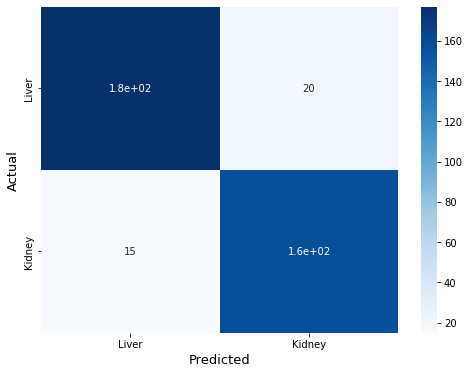

In [46]:
# Confusion matrix small model
plot_confusion_matrix(None, 
                      conf_matrix_small, 
                      'confusion_matrix_small',
                      'jpg')

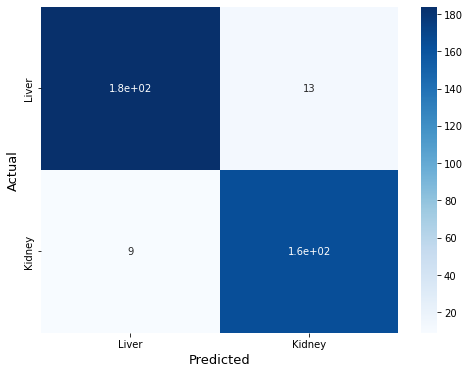

In [47]:
# Confusion matrix larger model
plot_confusion_matrix(None, 
                      conf_matrix_larger, 
                      'confusion_matrix_larger',
                      'jpg')

In [48]:
# Performance on test set
metrics_small = compute_metrics(y_true, y_score_small)
metrics_larger = compute_metrics(y_true, y_score_larger)
res = pd.DataFrame.from_dict([metrics_small, metrics_larger], 
                             orient='columns').round(3)
res.index = ['small', 'larger']
res

,accuracy,precision,recall,f1,roc_auc
small,0.905,0.905,0.906,0.905,0.980
larger,0.941,0.940,0.941,0.940,0.988


In [49]:
# Plot ROC curve
prop_min=0.05
label_prop = y_hot.mean(axis=0).reindex(labels)
indices = [ind for ind in range(len(labels)) if label_prop.iloc[ind] >= prop_min]
display(label_prop)
print(f"Indices to plot: {indices}")

Kidney    0.468581
Liver     0.531419
dtype: float64

Indices to plot: [0, 1]


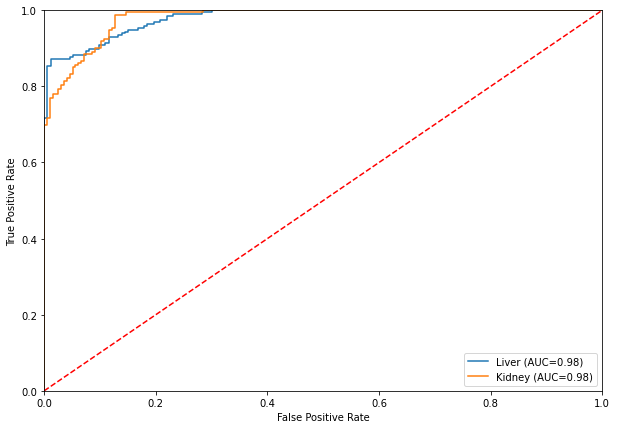

In [50]:
# ROC curve small model
plot_roc_curve(
    None, 
    y_true_ind,
    y_score_small,
    indices,
    "roc_small",
    "jpg"
)

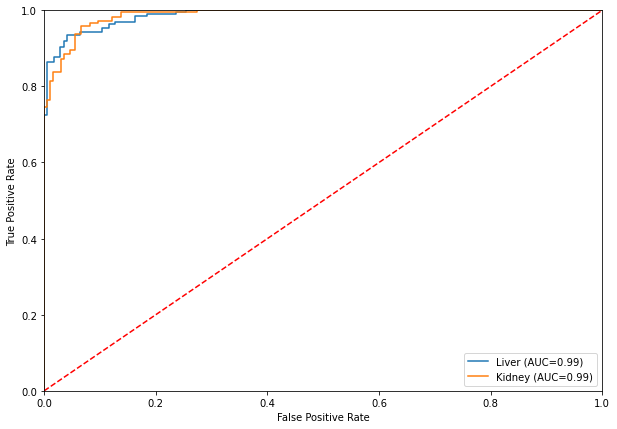

In [51]:
# ROC curve larger model
plot_roc_curve(
    None, 
    y_true_ind,
    y_score_larger,
    indices,
    "roc_larger",
    "jpg"
)